```
import Pyro4.util
try:
    [run your usual rfsoc experiment here]
except Exception:
    print("Pyro traceback:")
    print("".join(Pyro4.util.getPyroTraceback()))
```

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt

from qick import *
from qick.helpers import gauss
from tqdm import tqdm_notebook as tqdm

import time
import os
import sys
sys.path.append('/home/xilinx/jupyter_notebooks/')
import scipy as sp
import json
from scipy.fft import fft, fftfreq

from slab.instruments import *
from slab.experiment import Experiment
from slab.datamanagement import SlabFile
from slab import get_next_filename, AttrDict

# Figure params
plt.rcParams['figure.figsize'] = [10,6]
plt.rcParams.update({'font.size': 14})

Could not import QickSoc: No module named 'pynq'


c:\Users\slab\anaconda3\lib\site-packages\visa.py:13: FutureWarning: The visa module provided by PyVISA is being deprecated. You can replace `import visa` by `import pyvisa as visa` to achieve the same effect.

The reason for the deprecation is the possible conflict with the visa package provided by the https://github.com/visa-sdk/visa-python which can result in hard to debug situations.
  warnings.warn(
c:\Users\slab\anaconda3\lib\site-packages\IPython\qt.py:12: ShimWarning: The `IPython.qt` package has been deprecated since IPython 4.0. You should import from qtconsole instead.
  warn("The `IPython.qt` package has been deprecated since IPython 4.0. "


Warning serial library import failed.
Could not load InstrumentManagerWindow
Could not import QickInstrument, try install qick package
Could not load AD5780 dac 
Could not load labbrick
Could not load Autonics TM4 Driver
Could not load Oxford Trition driver


# Load experiments

In [2]:
# %aimport experiments
# NOTE: ADDING NEW METHODS WILL NOT BE UPDATED
import experiments as meas

imported experiments.clifford_averager_program
imported experiments.fitting
imported experiments.qram_protocol_timestepped
imported experiments.single_qubit.acstarkshift_spectroscopy
imported experiments.single_qubit.amplitude_rabi
imported experiments.single_qubit.length_rabi
imported experiments.single_qubit.pulse_probe_ef_spectroscopy
imported experiments.single_qubit.pulse_probe_spectroscopy
imported experiments.single_qubit.resonator_spectroscopy
imported experiments.single_qubit.rfsoc_tof_calibration
imported experiments.single_qubit.single_shot
imported experiments.single_qubit.t1
imported experiments.single_qubit.t2_echo
imported experiments.single_qubit.t2_ramsey
imported experiments.two_qubit.amplitude_rabi_EgGf
imported experiments.two_qubit.length_rabi_EgGf
imported experiments.two_qubit.pulse_probe_coupling_spectroscopy
imported experiments.two_qubit.pulse_probe_EgGf_spectroscopy
imported experiments.two_qubit.randbench
imported experiments.two_qubit.twoqutrit_state_tomogr

In [3]:
"""Reopen saved data"""
def prev_data(expt_path, filename):
    temp_data_file = expt_path+'/'+filename
    with SlabFile(temp_data_file) as a:
        attrs = dict()
        for key in list(a.attrs):
            attrs.update({key:json.loads(a.attrs[key])})
        keys = list(a)
        temp_data = dict()
        for key in keys:
            temp_data.update({key:np.array(a[key])})
        print(f'Extracted data and attrs {list(a.attrs)}')
    return temp_data, attrs

In [4]:
# expt_path=os.getcwd()+'\data\data_220712'
# expt_path=os.getcwd()+'\data\data_220801'
# expt_path=os.getcwd()+'\data\data_220904'
# expt_path=os.getcwd()+'\data\data_220919'
# expt_path=os.getcwd()+'\data\data_220929'
# expt_path=os.getcwd()+'\data\data_221007'
expt_path=os.getcwd()+'\data\data_221215'
print('Data will be stored in', expt_path)

Data will be stored in s:\Connie\experiments\qramLL_4QR2\data\data_221215


In [17]:
# config_file = 'config_zcu216.yml'
config_file = 'config_q3diamond.yml'
config_path = os.getcwd() + '\\' + config_file
print('Config will be', config_path)

Config will be s:\Connie\experiments\qramLL_4QR2\config_q3diamond.yml


# Qubit/resonator to probe

In [16]:
qubit_i = 1

# Setup experiment hardware

Set in config:
- LO alias, frequency, power
- SOC dac channels, nyquist zones

In [9]:
import yaml
with open(config_file, 'r') as cfg_file:
    yaml_cfg = yaml.safe_load(cfg_file)
yaml_cfg = AttrDict(yaml_cfg)

In [10]:
im = InstrumentManager(ns_address='192.168.14.1')

In [18]:
lo1 = im[yaml_cfg.aliases.readout_LO]
lo1.open_device()
print(lo1.get_id())

# # TURN OFF
# lo1.set_standby(True)
# lo1.set_output_state(False)

# TURN ON
lo1.set_standby(False)
lo1.set_output_state(True)
lo_freq = float(yaml_cfg.hw.lo.readout.frequency)
lo_power = float(yaml_cfg.hw.lo.readout.power)
lo1.set_frequency(lo_freq) # Set LO frequency
print(f'set freq to [MHz] {lo_freq*1e-6}')
lo1.set_power(lo_power) # Set LO power
print('set power to', lo_power)

Default Instrument SC_26C1
set freq to [MHz] 5925.0
set power to 7.0


In [11]:
soc = QickConfig(im[yaml_cfg['aliases']['soc']].get_cfg())
print(soc)
# print(soc.description())
# print(soc.dump_cfg())


QICK configuration:

	Board: ZCU216

	Global clocks (MHz): tProcessor 349.997, RF reference 245.760

	7 signal generator channels:
	0:	axis_sg_int4_v1 - tProc output 0, envelope memory 4096 samples
		DAC tile 2, ch 0, 16-bit DDS, fabric=430.080 MHz, fs=1720.320 MHz
	1:	axis_sg_int4_v1 - tProc output 1, envelope memory 4096 samples
		DAC tile 2, ch 1, 16-bit DDS, fabric=430.080 MHz, fs=1720.320 MHz
	2:	axis_sg_int4_v1 - tProc output 2, envelope memory 4096 samples
		DAC tile 2, ch 2, 16-bit DDS, fabric=430.080 MHz, fs=1720.320 MHz
	3:	axis_sg_int4_v1 - tProc output 3, envelope memory 4096 samples
		DAC tile 2, ch 3, 16-bit DDS, fabric=430.080 MHz, fs=1720.320 MHz
	4:	axis_signal_gen_v6 - tProc output 4, envelope memory 65536 samples
		DAC tile 3, ch 0, 32-bit DDS, fabric=599.040 MHz, fs=9584.640 MHz
	5:	axis_signal_gen_v6 - tProc output 5, envelope memory 65536 samples
		DAC tile 3, ch 1, 32-bit DDS, fabric=599.040 MHz, fs=9584.640 MHz
	6:	axis_sg_mux4_v2 - tProc output 6, envelope mem

# RFSoC Calibration

In [11]:
pulse_length =      soc.us2cycles(9.9, gen_ch=6)
readout_length =    soc.us2cycles(9.9, ro_ch=0)
print(soc.cycles2us(4*5, gen_ch=4))
print(soc.cycles2us(95, ro_ch=0))
print(soc.us2cycles(soc.cycles2us(95, gen_ch=6), ro_ch=0))
print(pulse_length, readout_length, readout_length-pulse_length)

0.033386752136752136
0.3092447916666667
68
4258 3041 -1217


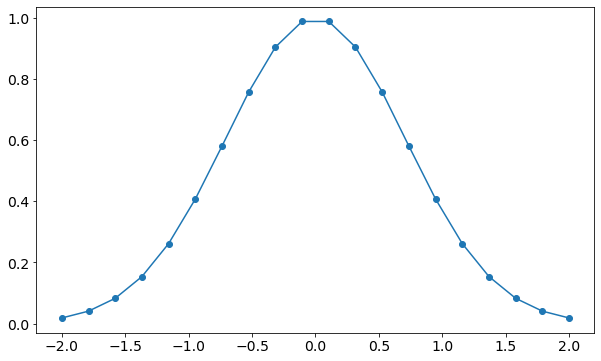

In [38]:
x = np.linspace(-2, 2, 5*4)
y = np.exp(-x**2)
plt.plot(x, y, 'o-')

In [68]:
tof = meas.ToFCalibrationExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"adc_trig_offset_calibration_qubit{qubit_i}",
    config_file=config_path,
)

tof.cfg.expt = dict(
    pulse_length=0.5, # [us]
    readout_length=1.0, # [us]
    trig_offset=0, # [clock ticks]
    # gain=32000,
    gain=1.0, # [MUX units: -1 to 1]
    frequency=tof.cfg.device.readout.frequency[qubit_i], # [MHz]
    reps=500, # Number of averages per point
    # qubit=qubit_i,
    qubit=qubit_i,
)
tof.cfg.device.readout.relax_delay=0.1 # wait time between experiments [us]
print(tof.cfg)
tof.go(analyze=False, display=False, progress=True, save=False)

{'device': {'qubit': {'T1': [97, 96, 46, 58], 'f_ge': [823.0681204610527, 3464.4496477749913, 153.92796237453135, 447.5819924260869], 'f_Q1_ZZ': [3468.889513688846, 3470.20476419, 3465.25270434, 3469.12083078], 'f_ef': [633.210668158286, 3364.266, -71.90192894145498, 275.76433968698353], 'f_EgGf': [2009.95, 3364.24341488, 2683.62545251, 2389.97142246], 'gs': [43, 0, 54, 40], 'pulses': {'pi_ge': {'gain': [22692, 22147, 22539, 28755], 'sigma': [0.0386, 0.01836, 0.0433, 0.0276], 'type': ['gauss', 'gauss', 'gauss', 'gauss']}, 'pi_ef': {'gain': [12488, 14667, 20765, 29402], 'sigma': [0.025, 0.025, 0.035, 0.015], 'type': 'gauss'}, 'pi_Q1_ZZ': {'gain': [25000, 0, 25000, 25000], 'sigma': [0.0174, 0, 0.016, 0.0175], 'type': ['gauss', 'gauss', 'gauss', 'gauss']}, 'pi_EgGf': {'gain': [3450, 0, 2750, 2850], 'sigma': [0.2186, 0, 0.232, 0.29], 'type': 'const'}}}, 'readout': {'trig_offset': 125, 'frequency': [818.885, -812.72, -73.8, 87.5], 'lo_sideband': [1, -1, 1, 1], 'gain': [0.7, 0.5, 0.1, 0.2], 

  0%|          | 0/500 [00:00<?, ?it/s]

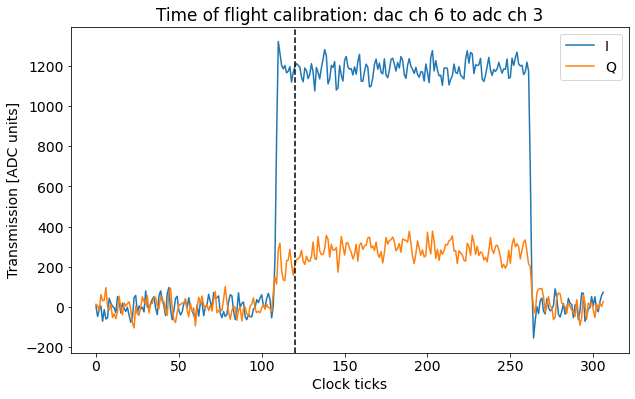

In [69]:
tof.display(adc_trig_offset=120)

In [131]:
tof.save_data()

Saving s:\Connie\experiments\202201xx_2Transmon_Connie/data\00000_adc_trig_offset_calibration_qubit1.h5


# Resonator spectroscopy

## Single tone (resonator) spectroscopy

Measures the resonant frequency of the readout resonator when the qubit is in its ground state: sweep readout pulse frequency and look for the frequency with the maximum measured amplitude.

The resonator frequency should be stored in the parameter <code>cfg.device.readouti.frequency</code>.

Note that harmonics of the clock frequency (6144 MHz) will show up as "infinitely"  narrow peaks!


In [56]:
rspec = meas.ResonatorSpectroscopyExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"resonator_spectroscopy_qubit{qubit_i}",
    config_file=config_path,
)

span = 2.0# MHz
npts = 150
# arduino.set_voltage(channel=4, voltage=0.0104)
rspec.cfg.expt = dict(
    start=rspec.cfg.device.readout.frequency[qubit_i]-span/2, # resonator frequency to be mixed up [MHz]
    # start=-807-span/2, # resonator frequency to be mixed up [MHz]
    # start=rspec.cfg.device.readout.frequency[qubit_i]-0.75*span,
    # start=rspec.cfg.device.readout.frequency[qubit_i]-0.25*span,
    # start=0,
    step=span/npts, # min step ~1 Hz
    expts=npts, # Number experiments stepping from start
    reps=3000, # Number averages per point
    pulse_e=False, # add ge pi pulse prior to measurement
    pulse_f=False, # add ef pi pulse prior to measurement
    qubit=qubit_i,
)

# rspec.cfg.device.readout.gain = 0.15

rspec.cfg.device.readout.relax_delay = 5 # Wait time between experiments [us]
rspec.cfg.device.readout.readout_length = 10
print(rspec.cfg)
rspec.go(analyze=False, display=False, progress=True, save=False)

{'device': {'qubit': {'T1': [24, 96, 30, 58], 'f_ge': [805.5035979539057, 3464.4496477749913, 145.572034953271, 425.57], 'f_Q1_ZZ': [3468.889513688846, 3470.20476419, 3465.25270434, 3469.12083078], 'f_ef': [617.0457654660589, 3364.2604416148333, -78.90376315971923, 275.76433968698353], 'f_EgGf': [2009.95, 3364.24341488, 2683.62545251, 2389.97142246], 'gs': [43, 0, 54, 40], 'pulses': {'pi_ge': {'gain': [30306, 22147, 24653, 28755], 'sigma': [0.03539, 0.01836, 0.0403, 0.0276], 'type': ['gauss', 'gauss', 'gauss', 'gauss']}, 'pi_ef': {'gain': [13626, 13553, 31065, 29402], 'sigma': [0.025, 0.025, 0.025, 0.015], 'type': 'gauss'}, 'pi_Q1_ZZ': {'gain': [25000, 0, 25000, 25000], 'sigma': [0.0174, 0, 0.016, 0.0175], 'type': ['gauss', 'gauss', 'gauss', 'gauss']}, 'pi_EgGf': {'gain': [3450, 0, 2750, 2850], 'sigma': [0.2186, 0, 0.232, 0.29], 'type': 'const'}}}, 'readout': {'trig_offset': 125, 'frequency': [818.946, -812.617, -73.825, 87.436], 'lo_sideband': [1, -1, 1, 1], 'gain': [0.86, 0.86, 0.48,

  0%|          | 0/150 [00:00<?, ?it/s]

[87.42933333333333, 5000, 1000, 0, 271.72391300595723, 169.6194807632058, 2.3988142171880686]

Freq with minimum transmission: 88.35600000000001
Freq with maximum transmission: 88.18266666666668
From fit:
	f0: 87.42933333333333
	Qi: 5000
	Qe: 1000
	Q0: 833.3333333333333
	kappa [MHz]: 0.10491520000000001
	phi [radians]: 0


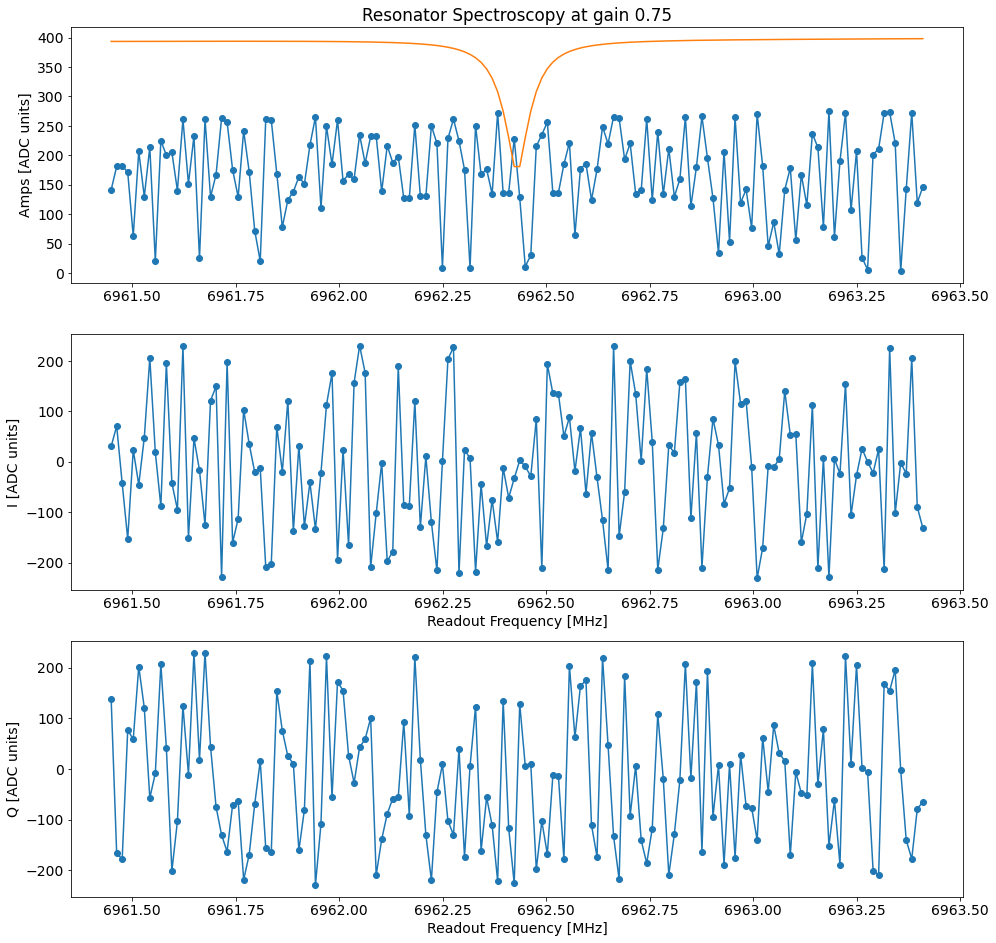

In [57]:
# # TESTING
# rspec = meas.ResonatorSpectroscopyExperiment(config_file=config_path,) 
# # temp_data, attrs = prev_data(expt_path, '00000_voltage_sweep_qubit_spectroscopy_qubit1.h5')
# temp_data, attrs = prev_data(expt_path, '00000_power_sweep_resonator_spectroscopy_qubit0.h5')
# i_gain = np.argmin(np.abs(temp_data['gainpts']-30))
# temp_data['amps'] = temp_data['amps'][i_gain][80:]
# temp_data['xpts'] = temp_data['xpts'][80:]
# data = rspec.analyze(data=temp_data, fit=True)
# rspec.display(data=data, fit=True)

rspec.analyze(fit=True, findpeaks=False)
rspec.display(fit=True, findpeaks=False)

In [36]:
rspec.save_data()

Saving s:\Connie\experiments\qramLL_4QR2\data\data_221215\00001_resonator_spectroscopy_qubit3.h5


## Power sweep resonator spectroscopy

Repeat resonator spectroscopy at a range of powers to check that resonator frequency shifts at low powers. (Check qubit is alive.)

Use this experiment to determine the appropriate resonator gain, which should be stored in <code>cfg.device.readout.gain</code>


In [281]:
rpowspec = meas.ResonatorPowerSweepSpectroscopyExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"power_sweep_resonator_spectroscopy_qubit{qubit_i}",
    config_file=config_path,
)

span_f = 2.5
npts_f = 150

span_gain = 0.9
npts_gain = 10

rpowspec.cfg.expt = dict(
    # start_f=rpowspec.cfg.device.readout.frequency[qubit_i]-span_f*0.75, # sweep frequency [MHz]
    start_f=rpowspec.cfg.device.readout.frequency[qubit_i]-span_f*0.5, # sweep frequency [MHz]
    step_f=span_f/npts_f, # min step ~1 Hz
    expts_f=npts_f, # Number experiments stepping freq from start
    # start_gain=rpowspec.cfg.device.readout.gain[qubit_i], # Gain sweep start [DAC units]
    start_gain=0.005,
    step_gain=span_gain/npts_gain, # Gain step size
    expts_gain=npts_gain, # Number experiments stepping gain from start
    reps=2000, # Number averages per point
    pulse_e=False, # add ge pi pulse before measurement
    pulse_f=False, # add ef pi pulse before measurement
    qubit=qubit_i,
)
rpowspec.cfg.device.readout.relax_delay = 5 # Wait time between experiments [us]

print(rpowspec.cfg)

rpowspec.go(analyze=False, display=False, progress=True, save=False)

{'device': {'qubit': {'T1': [70, 100, 47, 53], 'f_ge': [829.2747624572338, 3470.7039558072906, 164.22613127133465, 457.5215351802661], 'f_ef': [649.12, 3370.260942584849, -61.55489617309885, 295.9599], 'f_EgGf': [2013, -1, 2682, 2385.8], 'gs': [43, 0, 54, 40], 'pulses': {'pi_ge': {'gain': [30000, 30000, 19242, 12734], 'sigma': [0.135, 0.0882, 0.025, 0.015], 'type': ['gauss', 'gauss', 'gauss', 'gauss']}, 'pi_ef': {'gain': [3006, 22889, 20147, 3821], 'sigma': [0.035, 0.095, 0.025, 0.025], 'type': 'gauss'}, 'pi_EgGf': {'gain': [1000, 0, 7800, 10000], 'sigma': [0.1, 0, 0.17, 0.253], 'type': 'const'}}}, 'readout': {'trig_offset': 125, 'frequency': [812.37, -806.77, -82.015, 79.63708892384405], 'lo_sideband': [1, -1, 1, 1], 'gain': [0.3, 0.27, 0.017, 0.02], 'readout_length': [10, 10, 10, 10], 'relax_delay': 5}}, 'hw': {'soc': {'dacs': {'qubit': {'ch': [0, 5, 0, 0], 'type': ['int4', 'full', 'int4', 'int4'], 'mixer_freq': [4000, 0, 4000, 4000], 'nyquist': [2, 2, 2, 2]}, 'swap': {'ch': [4, -1, 

  0%|          | 0/10 [00:00<?, ?it/s]

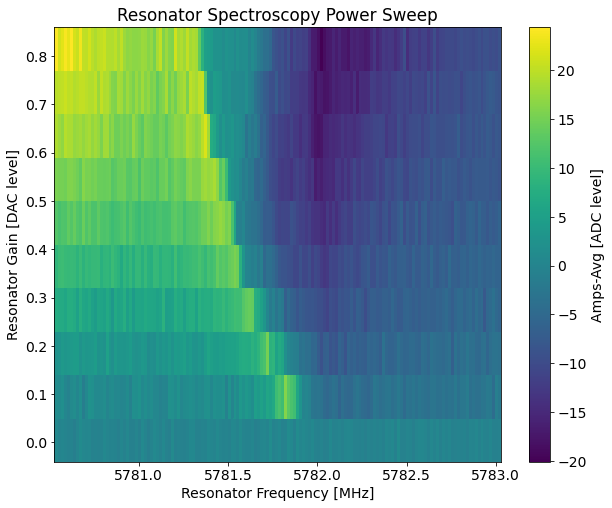

In [282]:
# # TESTING
# rpowspec = meas.ResonatorPowerSweepSpectroscopyExperiment(config_file=config_path)
# temp_data, attrs = prev_data(expt_path, '00000_power_sweep_resonator_spectroscopy_qubit1.h5')
# rpowspec.display(data=temp_data, fit=False)

rpowspec.analyze(fit=False, lowgain=None, highgain=None)
rpowspec.display(fit=False)

In [297]:
rpowspec.save_data()

Saving s:\Connie\experiments\qramLL_4QR2\data_220904\00000_power_sweep_resonator_spectroscopy_qubit1.h5


# Qubit ge spectroscopy

## Pulse Probe (qubit) spectroscopy

Measures the qubit frequency f_ge by driving at resonator frequency and sweeping qubit frequency.

Qubit frequency should be stored in <code>cfg.qubiti.f_ge</code>.

In [28]:
qspec = meas.PulseProbeSpectroscopyExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"qubit_spectroscopy_qubit{qubit_i}",
    config_file=config_path,
)

span = 25
npts = 150

qspec.cfg.expt = dict(
    start=qspec.cfg.device.qubit.f_ge[qubit_i]-span/2, # resonator frequency to be mixed up [MHz]
    # start=qspec.cfg.device.qubit.f_ge[qubit_i]-0.75*span, # resonator frequency to be mixed up [MHz]
    # start=3550,
    step=span/npts, # min step ~1 MHz
    expts=npts, # Number of experiments stepping from start
    reps=300, # Number of averages per point
    rounds=10, # Number of start to finish sweeps to average over
    length=10, # Qubit probe constant pulse length [us]
    gain=5000, # Qubit pulse gain
    qubit=qubit_i,
)
qspec.cfg.device.readout.relax_delay = 5 # Wait time between experiments [us]

print(qspec.cfg)

qspec.go(analyze=False, display=False, progress=True, save=False)

{'device': {'qubit': {'T1': [24, 96, 30, 58], 'f_ge': [805.5035979539057, 3464.4496477749913, 145.572034953271, 425.57], 'f_Q1_ZZ': [3463.98926186, 3464.44964777, 3460.52787362, 3463.90343458], 'f_ef': [617.0457654660589, 3364.2604416148333, -78.90376315971923, 275.76433968698353], 'f_EgGf': [2009.95, 3364.24341488, 2683.62545251, 2389.97142246], 'gs': [43, 0, 54, 40], 'pulses': {'pi_ge': {'gain': [30306, 22147, 24653, 28755], 'sigma': [0.03539, 0.01836, 0.0403, 0.0276], 'type': ['gauss', 'gauss', 'gauss', 'gauss']}, 'pi_ef': {'gain': [13626, 13553, 31065, 29402], 'sigma': [0.025, 0.025, 0.025, 0.015], 'type': 'gauss'}, 'pi_Q1_ZZ': {'gain': [25000, 0, 25000, 25000], 'sigma': [0.0174, 0, 0.016, 0.0175], 'type': ['gauss', 'gauss', 'gauss', 'gauss']}, 'pi_EgGf': {'gain': [3450, 0, 2750, 2850], 'sigma': [0.2186, 0, 0.232, 0.29], 'type': 'const'}}}, 'readout': {'trig_offset': 125, 'frequency': [818.946, -812.617, -73.825, 87.436], 'lo_sideband': [1, -1, 1, 1], 'gain': [0.86, 0.86, 0.48, 0.7

  0%|          | 0/10 [00:00<?, ?it/s]

Found peak in amps at [MHz] 806.3866140184722, HWHM 5.842624192845989
Found peak in I at [MHz] 806.087775593827, HWHM 5.471055701766541
Found peak in Q at [MHz] 806.2640970363631, HWHM 3.8485484381377035


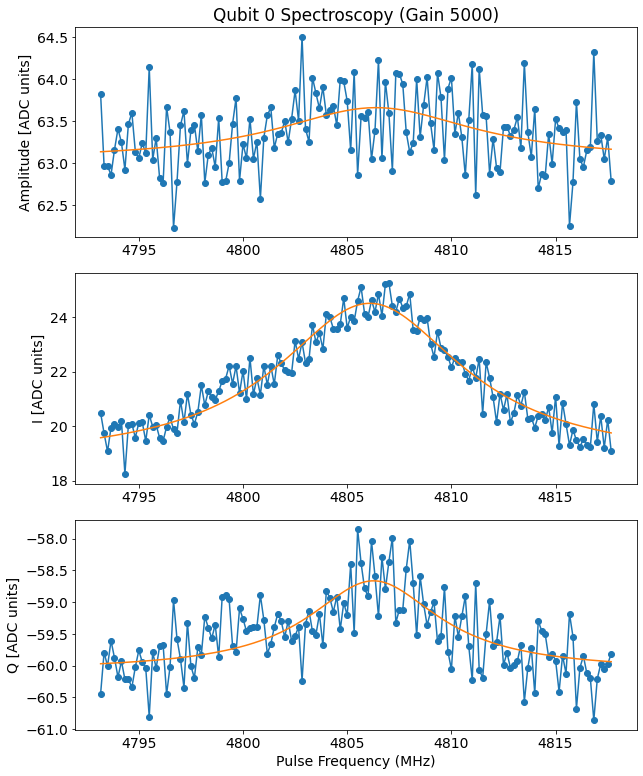

In [29]:
# # TESTING
# qspec = meas.PulseProbeSpectroscopyExperiment(config_file=config_path,)
# temp_data, attrs = prev_data(expt_path, '00001_qubit_spectroscopy_qubit1.h5')
# temp_data['avgi'] = temp_data['amps']
# data = qspec.analyze(data=temp_data, fit=True)
# qspec.display(data=data, fit=True)

qspec.analyze(fit=True, signs=[1, -1, 1])
qspec.display(fit=True, signs=[1, -1, 1])

In [270]:
qspec.save_data()

Saving s:\Connie\experiments\qramLL_4QR2\data_220904\00000_qubit_spectroscopy_qubit0.h5


## Length Rabi

Measures Rabi oscillations by sweeping over the duration of the qubit drive pulse. This is a preliminary measurement to prove that we see Rabi oscillations. This measurement is followed up by the Amplitude Rabi experiment below.


In [28]:
soc.cycles2us(5*50)

0.7142928572142864

In [14]:
lengthrabi = meas.LengthRabiExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"length_rabi_qubit{qubit_i}",
    config_file=config_path,
)

lengthrabi.cfg.expt = dict(
    start=0, # pulse length (sigma) [us]
    step=soc.cycles2us(1), # [us]
    # step=0.001,
    expts=101,
    reps=3000,
    gain=20000, # qubit gain [DAC units],
    gain=lengthrabi.cfg.device.qubit.pulses.pi_ge.gain[qubit_i],
    pulse_type='gauss',
    checkZZ=False,
    checkEF=False, 
    qubits=[qubit_i],
)
lengthrabi.cfg.device.readout.relax_delay = 100 # Wait time between experiments [us]

print(lengthrabi.cfg)
# lengthrabi.im[lengthrabi.cfg.aliases.soc].reset()
import Pyro4.util
try:
    lengthrabi.go(analyze=False, display=False, progress=True, save=False)
except Exception:
    print("Pyro traceback:")
    print("".join(Pyro4.util.getPyroTraceback()))

{'device': {'qubit': {'T1': [24, 96, 30, 58], 'f_ge': [810.826541944993, 3464.727488396267, 145.572034953271, 425.57], 'f_Q1_ZZ': [3463.826339688734, 0, 3459.6698976969255, 3463.5104694090664], 'f_ef': [611.098326885819, 3364.253, -78.90376315971923, 275.76433968698353], 'f_EgGf': [2010.8, 0, 2678.7, 2395.5], 'gs': [43, 0, 54, 40], 'pulses': {'pi_ge': {'gain': [16026, 22147, 24653, 28755], 'sigma': [0.066, 0.01836, 0.0403, 0.0276], 'type': ['gauss', 'gauss', 'gauss', 'gauss']}, 'pi_ef': {'gain': [16026, 13553, 31065, 29402], 'sigma': [0.025, 0.025, 0.025, 0.015], 'type': 'gauss'}, 'pi_Q1_ZZ': {'gain': [27777, 0, 16840, 30000], 'sigma': [0.015, 0, 0.024187907740573854, 0.015], 'type': ['gauss', 'gauss', 'gauss', 'gauss']}, 'pi_EgGf': {'gain': [4250, 0, 2679, 2850], 'sigma': [0.171, 0, 0.227, 0.293], 'type': 'const'}}}, 'readout': {'trig_offset': 125, 'frequency': [818.946, -812.617, -73.825, 87.436], 'lo_sideband': [1, -1, 1, 1], 'gain': [0.86, 0.86, 0.48, 0.75], 'readout_length': [10, 

  0%|          | 0/101 [00:00<?, ?it/s]

Attempted to init fitparam 1 to 76.99923000000001, which is out of bounds 0.3535318181818182 to 53.02977272727273. Instead init to 26.691652272727275
Attempted to init fitparam 1 to 129.49870500000003, which is out of bounds 0.3535318181818182 to 53.02977272727273. Instead init to 26.691652272727275
Attempted to init fitparam 1 to 94.49905500000001, which is out of bounds 0.3535318181818182 to 53.02977272727273. Instead init to 26.691652272727275
Decay from avgi [us] 0.08485799143705725
Pi length from avgi data [us]: 0.02535422468321642
	Pi/2 length from avgi data [us]: 0.01267711234160821

Decay from avgq [us] 0.08485799143705725
Pi length from avgq data [us]: 0.022240531499960553
Pi/2 length from avgq data [us]: 0.011120265749980277


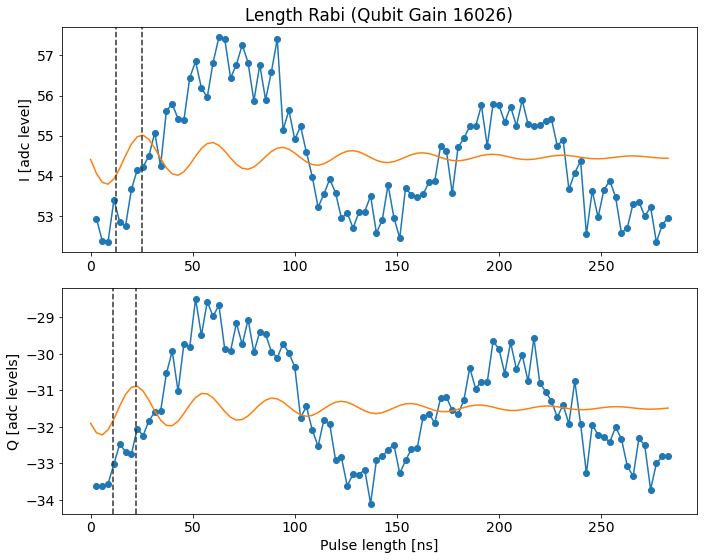

In [15]:
# # TESTING
# temp_data, attrs = prev_data(expt_path, '00000_voltage_sweep_qubit_spectroscopy_qubit3.h5')
# data = lengthrabi.analyze(data=temp_data, fit=True)

lengthrabi.analyze(fit=True)
lengthrabi.display(fit=True)

In [273]:
lengthrabi.save_data()

Saving s:\Connie\experiments\qramLL_4QR2\data_220904\00000_length_rabi_qubit0.h5


's:\\Connie\\experiments\\qramLL_4QR2\\data_220904\\00000_length_rabi_qubit0.h5'

## Amplitude Rabi

Measures Rabi oscillations by sweeping over the amplitude of the qubit drive pulse, which is a Gaussian pulse with sigma set by <code>cfg.device.qubiti.pulses.pi_ge.sigma</code>. We measure the $\pi$ pulse amplitude which are used in subsequent experiments to control the qubit, which should be stored in <code>cfg.device.qubiti.pulses.pi_ge.gain</code>.

In [12]:
amprabi = meas.AmplitudeRabiExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"amp_rabi_qubit{qubit_i}",
    config_file=config_path,
)

span = 32000
npts = 101
    
amprabi.cfg.expt = dict(
    start=0, # qubit gain [dac level]
    step=int(span/npts), # [dac level]
    expts=npts,
    reps=100,
    rounds=20,
    # sigma_test=0.025, # gaussian sigma for pulse length - overrides config [us]
    pulse_type='gauss',
    checkZZ=False,
    checkEF=False, 
    qubits=[qubit_i],
)

# amprabi.cfg.device.readout.relax_delay = 100 # Wait time between experiments [us]

print(amprabi.cfg)

amprabi.go(analyze=False, display=False, progress=True, save=False)

{'device': {'qubit': {'T1': [24, 96, 30, 58], 'f_ge': [810.826541944993, 3464.727488396267, 145.572034953271, 425.57], 'f_Q1_ZZ': [3463.826339688734, 0, 3459.6698976969255, 3463.5104694090664], 'f_ef': [611.098326885819, 3364.253, -78.90376315971923, 275.76433968698353], 'f_EgGf': [2010.8, 0, 2678.7, 2395.5], 'gs': [43, 0, 54, 40], 'pulses': {'pi_ge': {'gain': [16026, 22147, 24653, 28755], 'sigma': [0.066, 0.01836, 0.0403, 0.0276], 'type': ['gauss', 'gauss', 'gauss', 'gauss']}, 'pi_ef': {'gain': [16026, 13553, 31065, 29402], 'sigma': [0.025, 0.025, 0.025, 0.015], 'type': 'gauss'}, 'pi_Q1_ZZ': {'gain': [27777, 0, 16840, 30000], 'sigma': [0.015, 0, 0.024187907740573854, 0.015], 'type': ['gauss', 'gauss', 'gauss', 'gauss']}, 'pi_EgGf': {'gain': [4250, 0, 2679, 2850], 'sigma': [0.171, 0, 0.227, 0.293], 'type': 'const'}}}, 'readout': {'trig_offset': 125, 'frequency': [818.946, -812.617, -73.825, 87.436], 'lo_sideband': [1, -1, 1, 1], 'gain': [0.86, 0.86, 0.48, 0.75], 'readout_length': [10, 

  0%|          | 0/20 [00:00<?, ?it/s]

Attempted to init fitparam 1 to 0.0015822784810126584, which is out of bounds 3.196522183863956e-06 to 0.0004794783275795934. Instead init to 0.0002413374248817287
Attempted to init fitparam 1 to 0.000569620253164557, which is out of bounds 3.196522183863956e-06 to 0.0004794783275795934. Instead init to 0.0002413374248817287
Pi gain from avgi data [dac units]: 2309
	Pi/2 gain from avgi data [dac units]: 1154
Pi gain from avgq data [dac units]: 15595
	Pi/2 gain from avgq data [dac units]: 7797


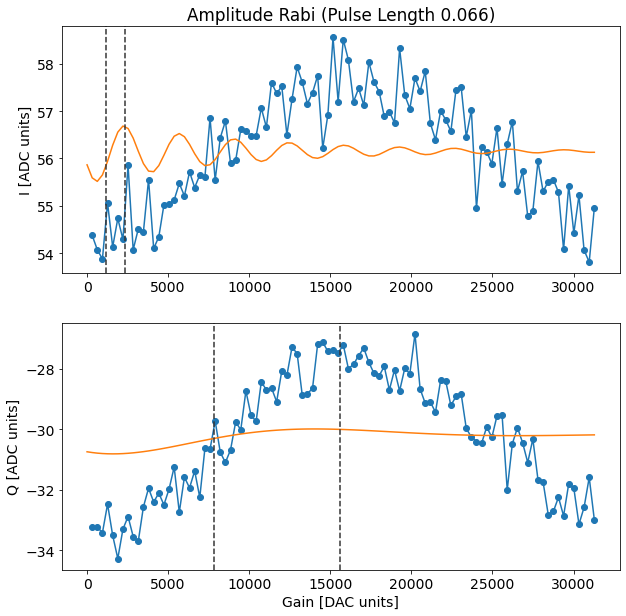

In [13]:
# # TESTING
# amprabi = meas.AmplitudeRabiExperiment(config_file=config_path,)
# temp_data, attrs = prev_data(expt_path, '00000_amp_rabi_qubit2.h5')
# data = amprabi.analyze(data=temp_data, fit=True)
# amprabi.display(data=data, fit=True)

amprabi.analyze(fit=True)
amprabi.display(fit=True)

In [71]:
amprabi.save_data()

Saving s:\Connie\experiments\qramLL_4QR2\data_220801\00000_amp_rabi_qubit1.h5


## Amplitude rabi qubit frequency sweep (chevron)

In [ ]:
amprabichev = meas.AmplitudeRabiChevronExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"amp_rabi_qubit_chevron{qubit_i}",
    config_file=config_path,
)

span_gain = 32000
npts_gain = 3

span_f = 5
npts_f = 5

amprabichev.cfg.expt = dict(
    start_f=4315,
    step_f=span_f/npts_f,
    expts_f=npts_f,
    start_gain=0, # qubit gain [dac level]
    step_gain=int(span_gain/npts_gain), # [dac level]
    expts_gain=npts_gain,
    reps=50,
    rounds=10,
    sigma_test=0.2, # gaussian sigma for pulse length - overrides config [us]
    pulse_type='gauss',
    qubit=qubit_i,
)

amprabichev.cfg.device.readout.relax_delay = 50 # Wait time between experiments [us]

print(amprabichev.cfg)

amprabichev.go(analyze=False, display=False, progress=True, save=False)

In [ ]:
# # TESTING
# temp_data_file = '/home/xilinx/jupyter_notebooks/_experiment/20211215_LL_StandardCandle1/data/00000_power_sweep_resonator_spectroscopy_qubit2.h5'
# with SlabFile(temp_data_file) as a:
#     temp_data = dict(
#         amps=np.asarray(a['amps']),
#         gainpts=np.asarray(a['gain']),
#         fpts=np.asarray(a['freq']),
#     )

# data = rpowspec.analyze(data=temp_data, lowgain=2000, highgain=18000)

amprabichev.analyze()
amprabichev.display()

In [ ]:
amprabichev.save_data()

## Single Shot

Measures the single shot readout fidelity of the system. We acquire single shot (I, Q) readout values by first preparing the qubit in its ground (blue dots) a certain number of times and then preparing the qubit in its excited state (red dots) the same number of times. We then extract two parameters which are used to optimize the associated readout fidelity: the rotation angle of the IQ blobs and the threshold that classifies the two qubit states (ground and excited). The two output parameters should be stored in <code>cfg.device.readouti.phase</code> and <code>cfg.device.readouti.threshold</code>.

Note that this experiment already assumes that you have found your qubit frequency and $\pi$ pulse amplitude. Every time you reset the QICK firmware the single shot angle and threshold changes. So, this experiment is used to calibrate any experiment below that uses single shot data (such as the Active Reset experiment).

In [24]:
shot = meas.HistogramExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"single_shot_qubit{qubit_i}",
    config_file=config_path,
)

shot.cfg.expt = dict(
    reps=20000,
    check_f=False,
    qubit=qubit_i,
)

# shot.cfg.device.readout.frequency=-82.015-0.54
# shot.cfg.device.readout.gain=0.900
# shot.cfg.device.readout.readout_length = 10 # [us]
# shot.cfg.device.readout.relax_delay = 70 # Wait time between experiments [us]
print(shot.cfg)

shot.go(analyze=False, display=False, progress=True, save=False)

{'device': {'qubit': {'T1': [97, 96, 46, 58], 'f_ge': [823.0681204610527, 3464.4496477749913, 153.92796237453135, 447.5819924260869], 'f_Q1_ZZ': [3468.889513688846, 3470.20476419, 3465.25270434, 3469.12083078], 'f_ef': [633.210668158286, 3364.266, -71.90192894145498, 275.76433968698353], 'f_EgGf': [2009.95, 3364.24341488, 2683.62545251, 2389.97142246], 'gs': [43, 0, 54, 40], 'pulses': {'pi_ge': {'gain': [22692, 22147, 22539, 28755], 'sigma': [0.0386, 0.01836, 0.0433, 0.0276], 'type': ['gauss', 'gauss', 'gauss', 'gauss']}, 'pi_ef': {'gain': [12488, 14667, 20765, 29402], 'sigma': [0.025, 0.025, 0.035, 0.015], 'type': 'gauss'}, 'pi_Q1_ZZ': {'gain': [25000, 0, 25000, 25000], 'sigma': [0.0174, 0, 0.016, 0.0175], 'type': ['gauss', 'gauss', 'gauss', 'gauss']}, 'pi_EgGf': {'gain': [3450, 0, 2750, 2850], 'sigma': [0.2186, 0, 0.232, 0.29], 'type': 'const'}}}, 'readout': {'trig_offset': 125, 'frequency': [818.885, -812.72, -73.8, 87.5], 'lo_sideband': [1, -1, 1, 1], 'gain': [0.7, 0.5, 0.1, 0.2], 

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

Unrotated:
Ig 0.9695737064757566 +/- 29.830513283453975 	 Qg -182.13439635535306 +/- 31.47898899996595 	 Amp g 182.13697704996957
Ie -1.4806378132118452 +/- 29.579377643080658 	 Qe -213.54702245362836 +/- 32.69485207118537 	 Amp e 213.55215542612623
Rotated:
Ig 181.39497482006297 +/- 29.830513283453975 	 Qg 15.182353291330896 +/- 31.47898899996595 	 Amp g 182.0292304588306
Ie 213.00182829550164 +/- 29.579377643080658 	 Qe 15.25708168175055 +/- 32.69485207118537 	 Amp e 213.5475530149432


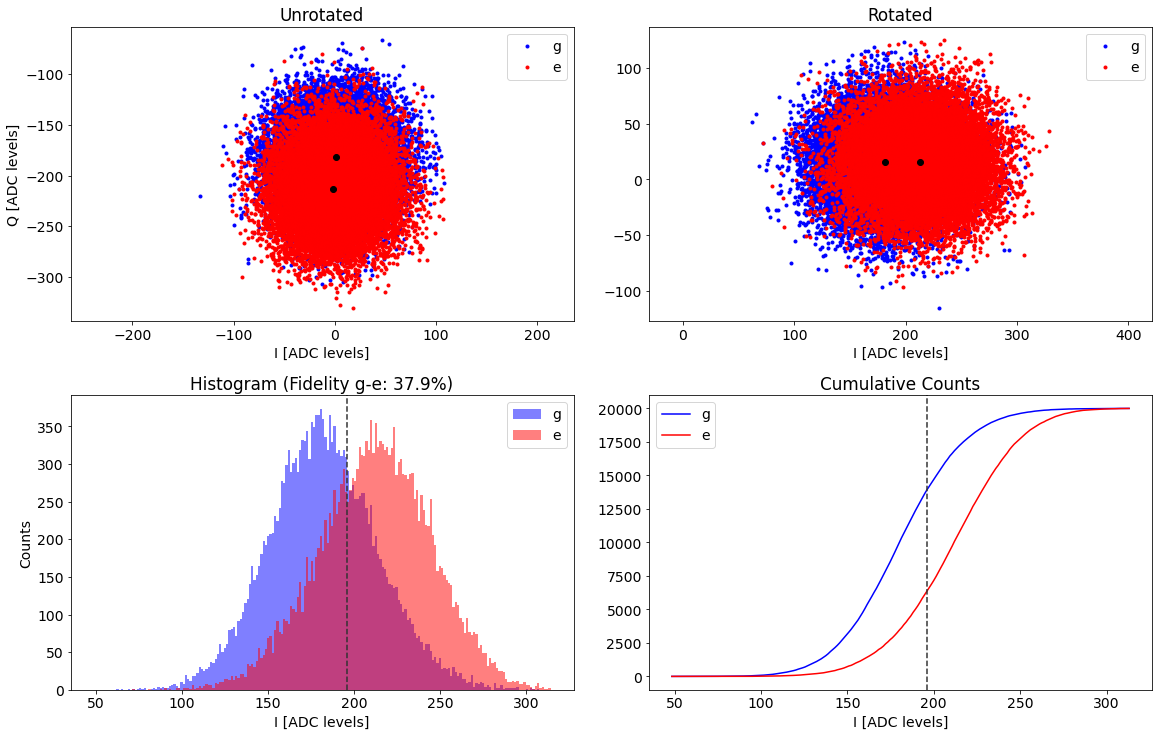

ge fidelity (%): 37.892841963147234
rotation angle (deg): 94.46008884452337
threshold ge: 196.02393590574482


In [25]:
# # TESTING
# shot = meas.HistogramExperiment(config_file=config_path)
# temp_data, attrs = prev_data(expt_path, '00001_single_shot_qubit0.h5')
# data = shot.analyze(data=temp_data)
# shot.display(data=data)

shot.analyze(verbose=False)
shot.display(verbose=True)

In [ ]:
# Checking for drift vs. shot number

data = shot.data
i = data['Ig']
q = data['Qg']
amps = np.abs(i+1j*q)
phases = np.angle(i+1j*q)

plt.plot(amps, label='amps')
plt.ylabel('Amps [ADC units]')
plt.xlabel('Shot number')
plt.legend()
plt.show()

plt.plot(phases, label='phases')
plt.ylabel('Phases [radians]')
plt.xlabel('Shot number')
plt.legend()
plt.show()

In [126]:
shot.save_data()

Saving s:\Connie\experiments\qramLL_4QR2\data_220904\00000_single_shot_qubit1.h5


### Single shot/readout optimization

In [57]:
shotopt = meas.SingleShotOptExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"single_shot_opt_qubit{qubit_i}",
    config_file=config_path,
)

span_f = 1 # MHz
npts_f = 5

span_gain = 0.07
# npts_gain = 2
npts_gain = 7

span_len = 9 # us
# npts_len = 2
npts_len = 3

shotopt.cfg.expt = dict(
    reps=100000,
    qubit=qubit_i,

    start_f=shotopt.cfg.device.readout.frequency[qubit_i] - 0.5*span_f,
    step_f=span_f/npts_f,
    expts_f=npts_f,

    # start_gain=int(shotopt.cfg.device.readout.gain[qubit_i] - 0.5*span_gain),
    # start_gain=int(shotopt.cfg.device.readout.gain[qubit_i]-span_gain/2),
    start_gain=0.01,
    step_gain=span_gain/npts_gain,
    expts_gain=npts_gain,

    start_len=3,
    step_len=span_len/npts_len,
    expts_len=npts_len,
)

print(shotopt.cfg)

shotopt.go(analyze=False, display=False, progress=True, save=False)

{'device': {'qubit': {'T1': [70, 120, 40, 5], 'f_ge': [743.119, 3476.716, 166.5217, 456.7], 'f_ef': [649.12, 3376.34, -59.294, 295.9599], 'f_EgGf': [2013, -1, 2682, 2385.8], 'gs': [43, 0, 54, 40], 'pulses': {'pi_ge': {'gain': [27145, 15419, 13869, 7000], 'sigma': [0.035, 0.025, 0.02, 0.025], 'type': 'gauss'}, 'pi_ef': {'gain': [4713, 10922, 14543, 4728], 'sigma': [0.02, 0.025, 0.025, 0.025], 'type': 'gauss'}, 'pi_EgGf': {'gain': [1000, 0, 7800, 10000], 'sigma': [0.1, 0, 0.17, 0.253], 'type': 'const'}}}, 'readout': {'trig_offset': 120, 'frequency': [810.409984606071, -805.0555447534924, -82.367068, 79.3372763161615], 'lo_sideband': [1, -1, 1, 1], 'gain': [0.085, 0.03, 0.025, 0.07], 'phase': [0, 0, 126.826, 0], 'threshold_ge': [0, 0, 5.5435, 0], 'threshold_ef': [1, 1, 1, 1], 'readout_length': [5, 5, 5, 5], 'relax_delay': [200, 300, 150, 50]}}, 'hw': {'lo': {'readout': {'frequency': '5925e6', 'power': 10}}, 'soc': {'dacs': {'qubit': {'ch': [0, 5, 0, 0], 'type': ['int4', 'full', 'int4', 'i

  0%|          | 0/5 [00:00<?, ?it/s]

In [63]:
shotopt.analyze()
print(shotopt.data['fid'])

(4, 6, 2)
[-805.55554475 -805.35554475 -805.15554475 -804.95554475 -804.75554475]
[0.01 0.02 0.03 0.04 0.05 0.06 0.07]
[3. 6. 9.]
Max fidelity 0.14115141151411514
Set params: 
 angle (deg) 79.27975364474388 
 threshold -74.77681231100001 
 freq [Mhz] -804.7555447534925 
 gain [dac units] 0.06999999999999999 
 readout length [us] 9.0
[[[0.00840008 0.01332007 0.00761008]
  [0.0196801  0.0201102  0.02307012]
  [0.03011015 0.02903029 0.02637013]
  [0.03112016 0.03297016 0.03285016]
  [0.03341017 0.03753019 0.04184021]
  [0.03855039 0.03842019 0.03890039]
  [0.04129021 0.04111021 0.03618018]]

 [[0.03064015 0.03299016 0.03118016]
  [0.03923039 0.04150042 0.04435044]
  [0.04181042 0.04555023 0.04756024]
  [0.04568023 0.05172026 0.04778024]
  [0.05450027 0.06252031 0.05771087]
  [0.0604203  0.05873059 0.06262031]
  [0.06284031 0.05775029 0.06450032]]

 [[0.04171021 0.04239021 0.04251021]
  [0.07371074 0.08122081 0.08335083]
  [0.06460032 0.06747034 0.06370032]
  [0.05880029 0.05490027 0.05565

In [59]:
shotopt.save_data()

Saving s:\Connie\experiments\qramLL_4QR2\data_220712\00001_single_shot_opt_qubit1.h5


## $T_1$

Measures the qubit T1 characteristic decay time by preparing the qubit in its excited state with a $\pi$ pulse followed by a variable delay ($\tau$) before measuring the qubit's state. This exponential decay curve can be fitted in post-processing to obtain the qubit T1 time.

In [301]:
t1 = meas.T1Experiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"t1_qubit{qubit_i}",
    config_file=config_path,
)

span = 150
npts = 150

t1.cfg.expt = dict(
    start=0, # wait time [us]
    step=span/npts,
    expts=npts,
    reps=300,
    rounds=10,
    qubit=qubit_i,
)

t1.cfg.device.readout.relax_delay = 150 # Wait time between experiments [us]

print(t1.cfg)

t1.go(analyze=False, display=False, progress=True, save=False)

{'device': {'qubit': {'T1': [70, 100, 47, 53], 'f_ge': [829.2747624572338, 3470.7039558072906, 164.22613127133465, 457.5215351802661], 'f_ef': [649.12, 3370.260942584849, -61.55489617309885, 295.9599], 'f_EgGf': [2013, -1, 2682, 2385.8], 'gs': [43, 0, 54, 40], 'pulses': {'pi_ge': {'gain': [30000, 30000, 19242, 12734], 'sigma': [0.135, 0.0882, 0.025, 0.015], 'type': ['gauss', 'gauss', 'gauss', 'gauss']}, 'pi_ef': {'gain': [3006, 22889, 20147, 3821], 'sigma': [0.035, 0.095, 0.025, 0.025], 'type': 'gauss'}, 'pi_EgGf': {'gain': [1000, 0, 7800, 10000], 'sigma': [0.1, 0, 0.17, 0.253], 'type': 'const'}}}, 'readout': {'trig_offset': 125, 'frequency': [812.37, -806.77, -82.015, 79.63708892384405], 'lo_sideband': [1, -1, 1, 1], 'gain': [0.3, 0.27, 0.017, 0.02], 'readout_length': [10, 10, 10, 10], 'relax_delay': 150}}, 'hw': {'soc': {'dacs': {'qubit': {'ch': [0, 5, 0, 0], 'type': ['int4', 'full', 'int4', 'int4'], 'mixer_freq': [4000, 0, 4000, 4000], 'nyquist': [2, 2, 2, 2]}, 'swap': {'ch': [4, -1

  0%|          | 0/10 [00:00<?, ?it/s]

Fit T1 avgi [us]: 50.88669091243768
Fit T1 avgq [us]: 47.70792470891063


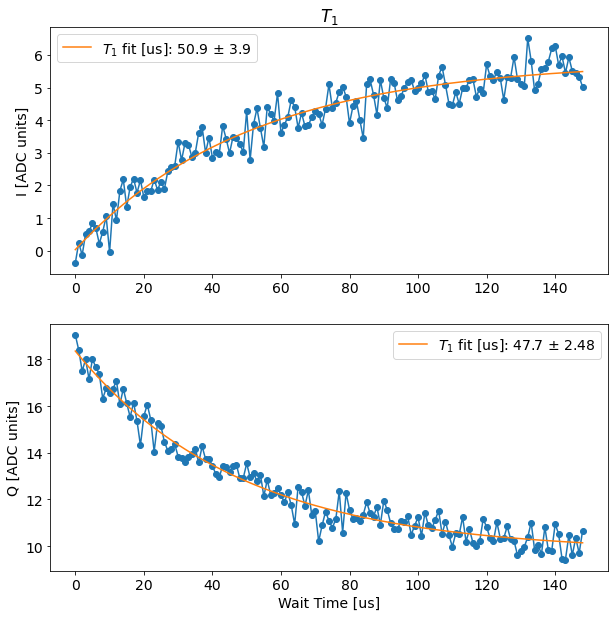

In [302]:
# # TESTING
# t1 = meas.T1Experiment(config_file=config_path,)
# temp_data, attrs = prev_data(expt_path, '00000_t1_qubit1.h5')
# data = t1.analyze(data=temp_data, fit=True)
# t1.display(data=data, fit=True)

t1.analyze(fit=True)
t1.display()

In [303]:
t1.save_data()

Saving s:\Connie\experiments\qramLL_4QR2\data_220904\00000_t1_qubit0.h5


's:\\Connie\\experiments\\qramLL_4QR2\\data_220904\\00000_t1_qubit0.h5'

## $T_2$ Ramsey Fringe Experiment

Measures the qubit $T_2$ Ramsey characteristic decay time by preparing the qubit in a superposition state with a  $\frac{\pi}{2}$ pulse (about X-axis) followed by a variable delay ($\tau$) before applying another $\frac{\pi}{2}$ pulse (about X-axis) with a phase advanced by $\Delta \phi = \omega * \tau$, where $\omega$ is the Ramsey frequency.

When qubit frequency is off by $\Delta$, oscillations will be observed at $\omega+\Delta$. Iterate on this experiment, adjusting the qubit frequency, until no oscillations are observed.

This exponential decay envelope can be fitted in post-processing to obtain the qubit $T_2$ Ramsey time.

In [103]:
0.5/soc.cycles2us(10)

17.499825

In [26]:
t2r = meas.RamseyExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"ramsey_qubit{qubit_i}",
    config_file=config_path,
)

t2r.cfg.expt = dict(
    start=0, # wait time tau [us]
    step=soc.cycles2us(10), # [us] make sure nyquist freq = 0.5 * (1/step) > ramsey (signal) freq!
    # step=0.05, # [us]
    expts=151,
    ramsey_freq=3, # [MHz]
    reps=100,
    rounds=30,
    qubits=[qubit_i],
    checkZZ=False,
    checkEF=False,
)

t2r.cfg.device.readout.relax_delay = 3*t2r.cfg.device.qubit.T1[qubit_i] # Wait time b/w expts [us]

print(t2r.cfg)

import Pyro4.util
try:
    t2r.go(analyze=False, display=False, progress=True, save=False)
except Exception:
    print("Pyro traceback:")
    print("".join(Pyro4.util.getPyroTraceback()))

{'device': {'qubit': {'T1': [24, 96, 30, 58], 'f_ge': [805.5035979539057, 3464.4496477749913, 145.572034953271, 425.57], 'f_Q1_ZZ': [3463.98926186, 3464.44964777, 3460.52787362, 3463.90343458], 'f_ef': [617.0457654660589, 3364.2604416148333, -78.90376315971923, 275.76433968698353], 'f_EgGf': [2009.95, 3364.24341488, 2683.62545251, 2389.97142246], 'gs': [43, 0, 54, 40], 'pulses': {'pi_ge': {'gain': [30306, 22147, 24653, 28755], 'sigma': [0.03539, 0.01836, 0.0403, 0.0276], 'type': ['gauss', 'gauss', 'gauss', 'gauss']}, 'pi_ef': {'gain': [13626, 13553, 31065, 29402], 'sigma': [0.025, 0.025, 0.025, 0.015], 'type': 'gauss'}, 'pi_Q1_ZZ': {'gain': [25000, 0, 25000, 25000], 'sigma': [0.0174, 0, 0.016, 0.0175], 'type': ['gauss', 'gauss', 'gauss', 'gauss']}, 'pi_EgGf': {'gain': [3450, 0, 2750, 2850], 'sigma': [0.2186, 0, 0.232, 0.29], 'type': 'const'}}}, 'readout': {'trig_offset': 125, 'frequency': [818.946, -812.617, -73.825, 87.436], 'lo_sideband': [1, -1, 1, 1], 'gain': [0.86, 0.86, 0.48, 0.7

  0%|          | 0/30 [00:00<?, ?it/s]

Attempted to init fitparam 1 to 17.499824999999998, which is out of bounds 0.023489697986577185 to 3.5234546979865775. Instead init to 1.7734721979865773
Attempted to init fitparam 1 to 10.033233, which is out of bounds 0.023489697986577185 to 3.5234546979865775. Instead init to 1.7734721979865773
Current pi pulse frequency: 805.5035979539057
Fit frequency from I [MHz]: 0.12215218224947111 +/- 0.03675047464670922
Suggested new pi pulse frequency from fit I [MHz]:
 	808.3814457716562
 	802.3814457716562
T2 Ramsey from fit I [us]: 1.9391801603514593
Fit frequency from Q [MHz]: 1.8988126947123993 +/- 0.0788086202654729
Suggested new pi pulse frequencies from fit Q [MHz]:
 	806.6047852591932
 	800.6047852591932
T2 Ramsey from fit Q [us]: 2.1404970124652123


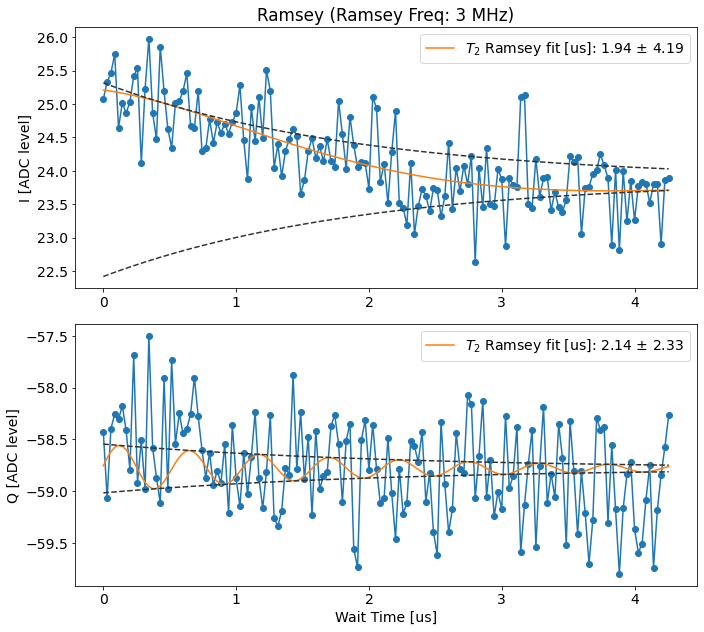

In [27]:
# # TESTING
# t2r = meas.RamseyExperiment(config_file=config_path)
# t2r.cfg.expt = dict(ramsey_freq=1, qubit=qubit_i)
# temp_data, attrs = prev_data(expt_path, '00000_ramsey_qubit1.h5')
# data = t2r.analyze(data=temp_data, fit=True)
# t2r.display(data=data, fit=True)

t2r.analyze(fit=True)
t2r.display(fit=True)

In [313]:
# # TESTING
# t2r = meas.RamseyExperiment(config_file=config_path)
# t2r.cfg.expt = dict(ramsey_freq=2, qubit=qubit_i)
# temp_data, attrs = prev_data(expt_path, '00000_ramsey_qubit1.h5')
# data = t2r.analyze(data=temp_data, fit=True)
# t2r.display(data=data, fit=True)

t2r.save_data()

Saving s:\Connie\experiments\qramLL_4QR2\data_220904\00001_ramsey_qubit0.h5


's:\\Connie\\experiments\\qramLL_4QR2\\data_220904\\00001_ramsey_qubit0.h5'

## $T_2$ Echo

Same idea as Ramsey, but add additional $\pi$ pulses in the middle of $\tau$  which prevent the qubit from decaying as quickly.

In [166]:
0.5/soc.cycles2us(10)

17.499825

In [314]:
t2e = meas.RamseyEchoExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"echo_qubit{qubit_i}",
    config_file=config_path,
)

t2e.cfg.expt = dict(
    start=0, # total wait time b/w the two pi/2 pulses [us]
    step=soc.cycles2us(70), # make sure nyquist freq = 0.5*(1/step) > ramsey (signal) freq!
    expts=151,
    ramsey_freq=0.200, # frequency by which to advance phase [MHz]
    num_pi=1, # number of pi pulses
    cpmg=True, # set either cp or cpmg to True
    cp=False, # set either cp or cpmg to True
    reps=300,
    rounds=10,
    qubit=qubit_i,
)

t2e.cfg.device.readout.relax_delay = 3*t2e.cfg.device.qubit.T1[qubit_i] # Wait time b/w expts [us]

print(t2e.cfg)

t2e.go(analyze=False, display=False, progress=True, save=False)

{'device': {'qubit': {'T1': [50, 100, 47, 53], 'f_ge': [830.2860170583211, 3470.7039558072906, 164.22613127133465, 457.5215351802661], 'f_ef': [649.12, 3370.260942584849, -61.55489617309885, 295.9599], 'f_EgGf': [2013, -1, 2682, 2385.8], 'gs': [43, 0, 54, 40], 'pulses': {'pi_ge': {'gain': [30000, 30000, 19242, 12734], 'sigma': [0.135, 0.0882, 0.025, 0.015], 'type': ['gauss', 'gauss', 'gauss', 'gauss']}, 'pi_ef': {'gain': [3006, 22889, 20147, 3821], 'sigma': [0.035, 0.095, 0.025, 0.025], 'type': 'gauss'}, 'pi_EgGf': {'gain': [1000, 0, 7800, 10000], 'sigma': [0.1, 0, 0.17, 0.253], 'type': 'const'}}}, 'readout': {'trig_offset': 125, 'frequency': [812.37, -806.77, -82.015, 79.63708892384405], 'lo_sideband': [1, -1, 1, 1], 'gain': [0.3, 0.27, 0.017, 0.02], 'readout_length': [10, 10, 10, 10], 'relax_delay': 150}}, 'hw': {'soc': {'dacs': {'qubit': {'ch': [0, 5, 0, 0], 'type': ['int4', 'full', 'int4', 'int4'], 'mixer_freq': [4000, 0, 4000, 4000], 'nyquist': [2, 2, 2, 2]}, 'swap': {'ch': [4, -1

  0%|          | 0/10 [00:00<?, ?it/s]

Attempted to init fitparam 1 to 2.399976, which is out of bounds 0.003355671140939598 to 0.5033506711409397. Instead init to 0.25335317114093964
Current qubit frequency: 830.2860170583211
Fit frequency from I [MHz]: 0.20095088444649958 +/- 0.0003407127966735775
Suggested new qubit frequency from fit I [MHz]:
 	830.2850661738746
 	829.8850661738746
T2 Echo from fit I [us]: 43.4448402992487
Fit frequency from Q [MHz]: 0.2000552748518427 +/- 0.00029063091599373616
Suggested new qubit frequencies from fit Q [MHz]:
 	830.2859617834692
 	829.8859617834693
T2 Echo from fit Q [us]: 38.296084169531795


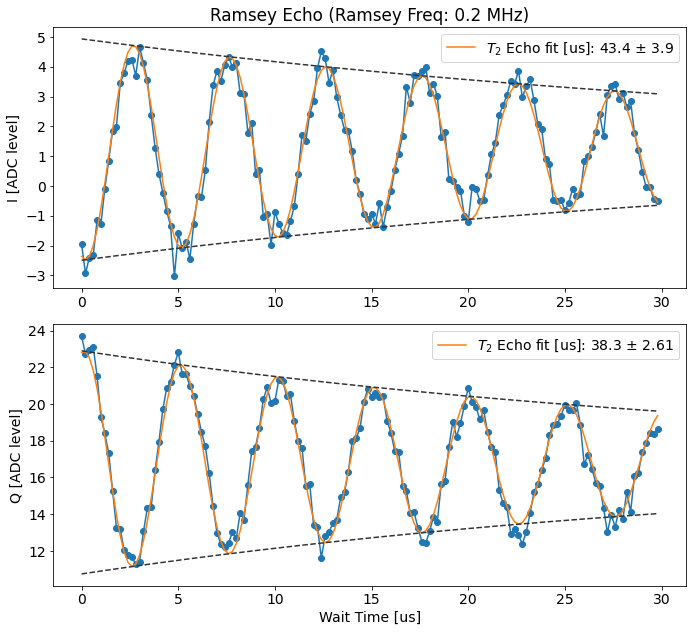

In [315]:
# # TESTING
# t2e = meas.RamseyEchoExperiment(config_file=config_path)
# t2e.cfg.expt = dict(ramsey_freq=1, qubit=qubit_i)
# temp_data, attrs = prev_data(expt_path, '00000_echo_qubit1.h5')
# data = t2e.analyze(data=temp_data, fit=True)
# t2e.display(data=data, fit=True)

t2e.analyze(fit=True)
t2e.display(fit=True)

In [316]:
t2e.save_data()

Saving s:\Connie\experiments\qramLL_4QR2\data_220904\00000_echo_qubit0.h5


's:\\Connie\\experiments\\qramLL_4QR2\\data_220904\\00000_echo_qubit0.h5'

# Qubit ef spectroscopy

## Pulse Probe ef spectroscopy

Qubit ef frequency should be stored in <code>cfg.qubiti.f_ef</code>.

In [403]:
qEFspec = meas.PulseProbeEFSpectroscopyExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"qubit_EF_spectroscopy_qubit{qubit_i}",
    config_file=config_path,
)

span = 50
npts = 150

qEFspec.cfg.expt = dict(
    start=qEFspec.cfg.device.qubit.f_ef[qubit_i]-0.5*span, # resonator frequency to be mixed up [MHz]
    # start=qEFspec.cfg.device.qubit.f_ge[qubit_i] - 50 - span,
    # start=3200,
    step=span/npts, # min step ~1 Hz
    expts=npts, # Number of experiments stepping from start
    reps=300, # Number of averages per point
    rounds=10, # Number of start to finish sweeps to average over
    length=10, # ef probe constant pulse length [us]
    gain=2000, # ef pulse gain
    qubit=qubit_i,
)

qEFspec.cfg.device.readout.relax_delay = 100 # Wait time between experiments [us]
print(qEFspec.cfg)

qEFspec.go(analyze=False, display=False, progress=True, save=False)

{'device': {'qubit': {'T1': [50, 100, 47, 53], 'f_ge': [828.193, 3470.7039558072906, 164.22613127133465, 457.5215351802661], 'f_ef': [637.4704365863639, 3370.260942584849, -61.55489617309885, 295.9599], 'f_EgGf': [2007.267, -1, 2682, 2385.8], 'gs': [43, 0, 54, 40], 'pulses': {'pi_ge': {'gain': [30000, 30000, 19242, 12734], 'sigma': [0.135, 0.0882, 0.025, 0.015], 'type': ['gauss', 'gauss', 'gauss', 'gauss']}, 'pi_ef': {'gain': [25271, 22889, 20147, 3821], 'sigma': [0.09, 0.095, 0.025, 0.025], 'type': 'gauss'}, 'pi_EgGf': {'gain': [2500, 0, 7800, 10000], 'sigma': [0.335, 0, 0.17, 0.253], 'type': 'const'}}}, 'readout': {'trig_offset': 125, 'frequency': [812.37, -806.77, -82.015, 79.63708892384405], 'lo_sideband': [1, -1, 1, 1], 'gain': [0.3, 0.27, 0.017, 0.02], 'readout_length': [10, 10, 10, 10], 'relax_delay': 100}}, 'hw': {'soc': {'dacs': {'qubit': {'ch': [0, 5, 0, 0], 'type': ['int4', 'full', 'int4', 'int4'], 'mixer_freq': [4000, 0, 4000, 4000], 'nyquist': [2, 2, 2, 2]}, 'swap': {'ch':

  0%|          | 0/10 [00:00<?, ?it/s]

Found peak in amps at [MHz] 3391.455507728651, HWHM 0.5074303319204367
Found peak in I at [MHz] 3370.1535795125715, HWHM -0.4514049599457906
Found peak in Q at [MHz] 3384.8560375107318, HWHM 0.15916113782467708


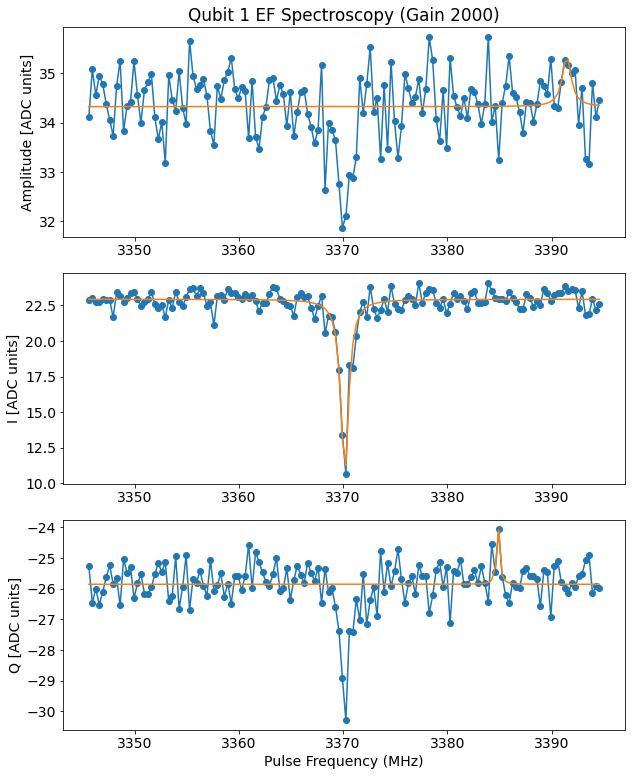

In [404]:
# # TESTING
# temp_data, attrs = prev_data(expt_path, '00000_voltage_sweep_qubit_spectroscopy_qubit3.h5')
# data = qEFspec.analyze(data=temp_data, fit=True)

qEFspec.analyze(fit=True, signs=[1, -1, 1])
qEFspec.display(fit=True, signs=[1, -1, 1])

In [334]:
qEFspec.save_data()

Saving s:\Connie\experiments\qramLL_4QR2\data_220904\00000_qubit_EF_spectroscopy_qubit0.h5


### Pulse probe EF power sweep

In [21]:
pulseprobeEFpowspec = meas.PulseProbeEFPowerSweepSpectroscopyExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"pulse_probe_ef_power_sweep_spectroscopy_qubit{qubit_i}",
    config_file=config_path,
)

span_f = 5
npts_f = 5

span_gain = 1000
npts_gain = 2

pulseprobeEFpowspec.cfg.expt = dict(
    start_f=pulseprobeEFpowspec.cfg.device.readout.frequency[qubit_i]-span_f/2, # Pulse frequency [MHz]
    step_f=span_f/npts_f, # min step ~1 Hz
    expts_f=npts_f, # Number experiments stepping freq from start
    # start_gain=pulseprobeEFpowspec.cfg.device.readout.gain[qubit_i], # Gain sweep start [DAC units]
    start_gain=1,
    step_gain=int(span_gain/npts_gain), # Gain step size
    expts_gain=npts_gain, # Number experiments stepping gain from start
    reps=10,
    rounds=10, # Number averages per point
    length=10, # ef const pulse length [us]
    qubit=qubit_i,
)
pulseprobeEFpowspec.cfg.device.readout.relax_delay = 2*pulseprobeEFpowspec.cfg.device.qubit.T1[qubit_i] # Wait time b/w expts [us]

print(pulseprobeEFpowspec.cfg)

pulseprobeEFpowspec.go(analyze=False, display=False, progress=True, save=False)

KeyboardInterrupt: 

In [ ]:
# # TESTING
# temp_data, attrs = prev_data(expt_path, '00000_voltage_sweep_qubit_spectroscopy_qubit3.h5')
# data = rpowspec.analyze(data=temp_data, lowgain=2000, highgain=18000)

pulseprobeEFpowspec.analyze(lowgain=None, highgain=None)
pulseprobeEFpowspec.display()

## Amplitude EF Rabi

The EF pi pulse amplitude should be stored in <code>cfg.device.qubit.pulses.pi_ef.gain</code>.

In [352]:
amprabiEF = meas.AmplitudeRabiEFExperiment(
    soccfg=soc,
    path=expt_path,
    prefix="amp_rabi_EF"+f"_qubit{qubit_i}",
    config_file=config_path,
)

span = 32000
npts = 101

amprabiEF.cfg.expt = dict(
    start=1, # qubit gain [dac level]
    step=int(span/npts), # [dac level]
    expts=npts,
    reps=500,
    rounds=20,
    sigma_test=0.0120, # gaussian sigma for pulse length - default from cfg [us]
    pulse_ge=False, # set to false when measuring qubit temp
    pulse_type='gauss',
    qubit=qubit_i,
)

print(amprabiEF.cfg)
amprabiEF.go(analyze=False, display=False, progress=True, save=False)

{'device': {'qubit': {'T1': [50, 100, 47, 53], 'f_ge': [830.2860170583211, 3470.7039558072906, 164.22613127133465, 457.5215351802661], 'f_ef': [616.5567916455193, 3370.260942584849, -61.55489617309885, 295.9599], 'f_EgGf': [2013, -1, 2682, 2385.8], 'gs': [43, 0, 54, 40], 'pulses': {'pi_ge': {'gain': [30000, 30000, 19242, 12734], 'sigma': [0.135, 0.0882, 0.025, 0.015], 'type': ['gauss', 'gauss', 'gauss', 'gauss']}, 'pi_ef': {'gain': [25271, 22889, 20147, 3821], 'sigma': [0.09, 0.095, 0.025, 0.025], 'type': 'gauss'}, 'pi_EgGf': {'gain': [1000, 0, 7800, 10000], 'sigma': [0.1, 0, 0.17, 0.253], 'type': 'const'}}}, 'readout': {'trig_offset': 125, 'frequency': [812.37, -806.77, -82.015, 79.63708892384405], 'lo_sideband': [1, -1, 1, 1], 'gain': [0.3, 0.27, 0.017, 0.02], 'readout_length': [10, 10, 10, 10], 'relax_delay': [150, 300, 140, 150]}}, 'hw': {'soc': {'dacs': {'qubit': {'ch': [0, 5, 0, 0], 'type': ['int4', 'full', 'int4', 'int4'], 'mixer_freq': [4000, 0, 4000, 4000], 'nyquist': [2, 2, 2

  0%|          | 0/20 [00:00<?, ?it/s]

Attempted to init fitparam 1 to 0.0009177215189873418, which is out of bounds 3.196522183863956e-06 to 0.0004794783275795934. Instead init to 0.0002413374248817287
Pi gain from avgi data [dac units]: 1344
	Pi/2 gain from avgi data [dac units]: 672
Pi gain from avgq data [dac units]: 913
	Pi/2 gain from avgq data [dac units]: 456


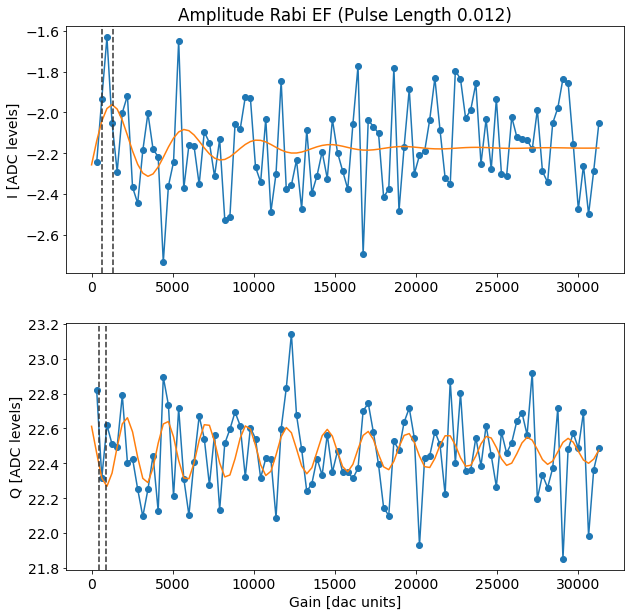

In [353]:
# # TESTING
# amprabiEF = meas.AmplitudeRabiEFExperiment(config_file=config_path)
# temp_data, attrs = prev_data(expt_path, '00000_ramseyEF_qubit0.h5')
# data = amprabiEF.analyze(data=temp_data, fit=True)
# amprabiEF.display(data=data, fit=True)

amprabiEF.analyze(fit=True)
amprabiEF.display(fit=True)

In [346]:
amprabiEF.save_data()

Saving s:\Connie\experiments\qramLL_4QR2\data_220904\00001_amp_rabi_EF_qubit0.h5


### Qubit temperature

In [347]:
# NATRUAL CONSTANTS
h = 6.62607015e-34
fge = 1e6*(amprabiEF.cfg.device.qubit.f_ge + amprabiEF.cfg.hw.soc.dacs.qubit.mixer_freq)
kB = 1.380649e-23
################

avgi = amprabiEF.data['avgi']

print(np.max(avgi) - np.min(avgi))
efamp_nopulse = 3.393557565896518
efamp_normal = 5.679627074520013

print('Qubit temp [mK]:', 1e3*-h*fge/(kB*np.log(efamp_nopulse/efamp_normal)))


5.679627074520013
Qubit temp [mK]: 110.48080963610299


## EF Ramsey Fringe
Update the ef frequency in <code>cfg.qubit.f_ef</code>.

In [155]:
1/(soc.cycles2us(1)*151)

2.3178576158940403

In [107]:
t2EFr = meas.RamseyEFExperiment(
    soccfg=soc,
    path=expt_path,
    prefix="ramseyEF"+f"_qubit{qubit_i}",
    config_file=config_path,
)

t2EFr.cfg.expt = dict(
    start=0, # wait time tau [us]
    step=soc.cycles2us(5), # [us] make sure nyquist freq = 0.5 * (1/step) > ramsey (signal) freq!
    # step=0.05, # [us]
    expts=151,
    ramsey_freq=2, # [MHz]
    reps=100,
    rounds=30,
    qubit=qubit_i,
)

print(t2EFr.cfg)

t2EFr.go(analyze=False, display=False, progress=True, save=False)

{'device': {'qubit': {'T1': [97, 53, 46, 58], 'f_ge': [823.0681204610527, 3473.31, 153.92796237453135, 447.5819924260869], 'f_Q1_ZZ': [3468.889513688846, 3470.20476419, 3465.25270434, 3469.12083078], 'f_ef': [640.5579612143589, 3376.181976811986, -71.90192894145498, 275.76433968698353], 'f_EgGf': [2009.9, -1, 2681.7, 2384.37], 'gs': [43, 0, 54, 40], 'pulses': {'pi_ge': {'gain': [22692, 23585, 22539, 28755], 'sigma': [0.0386, 0.0217, 0.0433, 0.0276], 'type': ['gauss', 'gauss', 'gauss', 'gauss']}, 'pi_ef': {'gain': [16093, 13843, 20765, 29402], 'sigma': [0.025, 0.025, 0.035, 0.015], 'type': 'gauss'}, 'pi_Q1_ZZ': {'gain': [25000, 0, 25000, 25000], 'sigma': [0.0174, 0, 0.016, 0.0175], 'type': ['gauss', 'gauss', 'gauss', 'gauss']}, 'pi_EgGf': {'gain': [3000, 0, 2750, 2850], 'sigma': [0.396, 0, 0.232, 0.29], 'type': 'const'}}}, 'readout': {'trig_offset': 125, 'frequency': [814.069, -808.35, -79.784, 81.64542225717739], 'lo_sideband': [1, -1, 1, 1], 'gain': [0.92, 0.3, 0.27, 0.85], 'readout_l

  0%|          | 0/10 [00:00<?, ?it/s]

Attempted to init fitparam 1 to 27.999719999999996, which is out of bounds 0.04697939597315437 to 7.046909395973155. Instead init to 3.5469443959731546
Attempted to init fitparam 1 to 8.399916, which is out of bounds 0.04697939597315437 to 7.046909395973155. Instead init to 3.5469443959731546
Current EF frequency: 640.5579612143589
Fit frequency from I [MHz]: 7.046909369482884
Suggested new EF frequencies from fit avgi [MHz]:
 	635.511051844876
 	631.511051844876
T2 Ramsey EF from fit avgi [us]: 0.13943671838720675
Fit frequency from Q [MHz]: 7.046909395973154
Suggested new EF frequencies from fit avgq [MHz]:
 	635.5110518183858
 	631.5110518183858
T2 Ramsey EF from fit avgq [us]: 0.11063573024758488


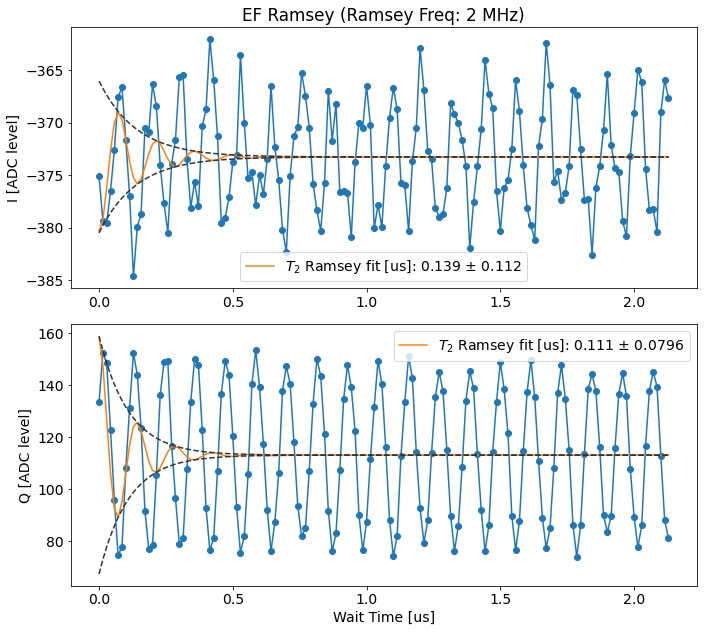

In [108]:
# # TESTING
# t2EFr = meas.RamseyEFExperiment(config_file=config_path)
# t2EFr.cfg.expt = dict(ramsey_freq=1, qubit=qubit_i)
# temp_data = prev_data(expt_path, '00000_ramseyEF_qubit0.h5')
# temp_data = temp_data[0]
# data = t2EFr.analyze(data=temp_data, fit=True)
# t2EFr.display(data=data, fit=True)

t2EFr.analyze(fit=True)
t2EFr.display(fit=True)

In [363]:
t2EFr.save_data()

Saving s:\Connie\experiments\qramLL_4QR2\data_220904\00001_ramseyEF_qubit0.h5


# AC stark shift

Determine how much effective power is being applied for a drive detuned from qubit frequency

In [28]:
acspec = meas.ACStarkShiftPulseProbeExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"ac_stark_shift_qubit{qubit_i}",
    config_file=config_path,
)

span_f = 50
npts_f = 150

span_gain = 30000
npts_gain = 5

pump_params=dict(
    ch=4,
    type='full',
    nyquist=1,
)

acspec.cfg.expt = dict(
    start_f=acspec.cfg.device.qubit.f_ge[qubit_i]-span_f/2, # Pulse frequency [MHz]
    step_f=span_f/npts_f,
    expts_f=npts_f,
    start_gain=1, # pump tone gain
    step_gain=int(span_gain/npts_gain),
    expts_gain=npts_gain,
    # pump_params=acspec.cfg.hw.soc.dacs.swap,
    pump_params=pump_params,
    # pump_freq=3300,
    pump_freq=acspec.cfg.device.qubit.f_EgGf[2],
    pump_length=12, # [us]
    qubit_gain=800,
    qubit_length=10, # [us]
    reps=1000,
    rounds=20, # Number averages per point
    qubit=qubit_i,
)
acspec.cfg.device.readout.relax_delay = 10
print(acspec.cfg)

acspec.go(analyze=False, display=False, progress=True, save=False)

{'device': {'qubit': {'T1': [70, 120, 40, 5], 'f_ge': [743.119, 3476.716, 166.5217, 449.757], 'f_ef': [649.12, 3376.34, -59.294, 295.9599], 'f_EgGf': [2105, -1, 2686.5343, 2403.299], 'gs': [43, 0, 54, 40], 'pulses': {'pi_ge': {'gain': [27145, 13869, 13869, 10606], 'sigma': [0.035, 0.015, 0.02, 0.025], 'type': 'gauss'}, 'pi_ef': {'gain': [4713, 22501, 14543, 4728], 'sigma': [0.02, 0.025, 0.025, 0.025], 'type': 'gauss'}, 'pi_EgGf': {'gain': [1000, 0, 1000, 1000], 'sigma': [0.1, 0, 0.1, 0.1], 'type': 'gauss'}}}, 'readout': {'trig_offset': 120, 'frequency': [810.409984606071, -805.058197780235, -82.367068, 79.3372763161615], 'lo_sideband': [1, -1, 1, 1], 'gain': [0.085, 0.03, 0.025, 0.07], 'phase': [0, 0, 0, 0], 'threshold_ge': [0, 0, 0, 0], 'threshold_ef': [1, 1, 1, 1], 'readout_length': [5, 5, 5, 5], 'relax_delay': 10}}, 'hw': {'lo': {'readout': {'frequency': '5925e6', 'power': 10}}, 'soc': {'dacs': {'qubit': {'ch': [0, 5, 0, 0], 'type': ['int4', 'full', 'int4', 'int4'], 'mixer_freq': [4

  0%|          | 0/5 [00:00<?, ?it/s]

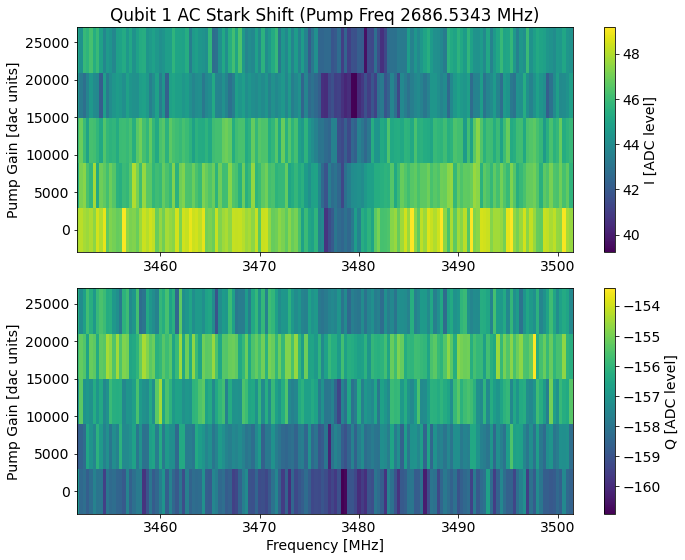

In [29]:
# # TESTING
# temp_data, attrs = prev_data(expt_path, '00000_voltage_sweep_qubit_spectroscopy_qubit3.h5')
# data = acspec.analyze(data=temp_data)

acspec.analyze()
acspec.display()

In [30]:
acspec.save_data()

Saving s:\Connie\experiments\qramLL_4QR2\data_220712\00002_ac_stark_shift_qubit1.h5


# Single qubit RB

{'device': {'qubit': {'T1': [97, 53, 46, 58], 'f_ge': [823.0681204610527, 3473.31, 153.92796237453135, 447.5819924260869], 'f_Q1_ZZ': [3468.889513688846, 3470.20476419, 3465.25270434, 3469.12083078], 'f_ef': [633.210668158286, 3364.2434148826505, -71.90192894145498, 275.76433968698353], 'f_EgGf': [2009.95, 3364.24341488, 2683.62545251, 2389.97142246], 'gs': [43, 0, 54, 40], 'pulses': {'pi_ge': {'gain': [22692, 23585, 22539, 28755], 'sigma': [0.0386, 0.0217, 0.0433, 0.0276], 'type': ['gauss', 'gauss', 'gauss', 'gauss']}, 'pi_ef': {'gain': [12488, 15332, 20765, 29402], 'sigma': [0.025, 0.025, 0.035, 0.015], 'type': 'gauss'}, 'pi_Q1_ZZ': {'gain': [25000, 0, 25000, 25000], 'sigma': [0.0174, 0, 0.016, 0.0175], 'type': ['gauss', 'gauss', 'gauss', 'gauss']}, 'pi_EgGf': {'gain': [3450, 0, 2750, 2850], 'sigma': [0.2186, 0, 0.232, 0.29], 'type': 'const'}}}, 'readout': {'trig_offset': 125, 'frequency': [814.069, -808.35, -79.784, 81.64542225717739], 'lo_sideband': [1, -1, 1, 1], 'gain': [0.92, 0.

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Qubit  (0)


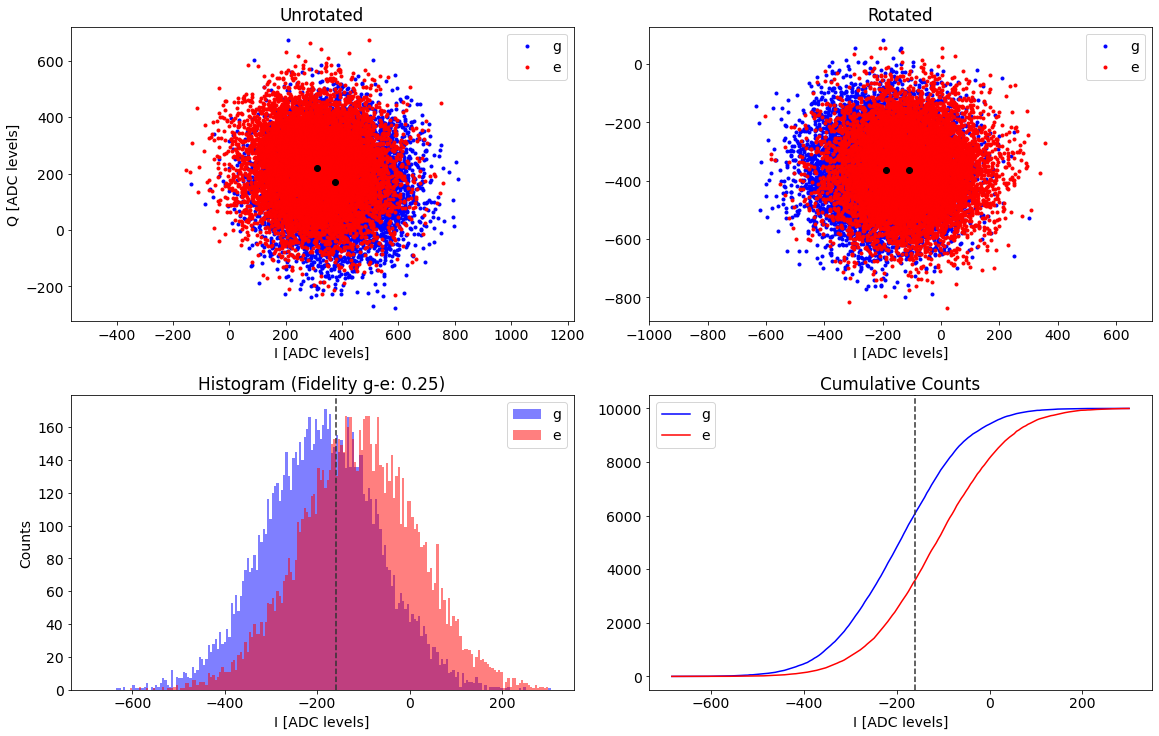

ge fidelity (%): 24.973746061909285 	 angle (deg): -142.06360567273813 	 threshold ge: -159.76791430708363
angles=[-142.06360567273813, 0, 0, 0]
thresholds=[-159.76791430708363, 0, 0, 0]
ge_avgs=[[373.5939400260332, 169.76653198828507, 310.40417552879916, 219.37187510575987], array([0., 0., 0., 0.]), array([0., 0., 0., 0.]), array([0., 0., 0., 0.])]


  0%|          | 0/15 [00:00<?, ?it/s]

s:\Connie\experiments\qramLL_4QR2\experiments\clifford_averager_program.py:330: RuntimeWarning: divide by zero encountered in true_divide
  avgi /= ge_avgs_rot[:,1] - ge_avgs_rot[:,0]
s:\Connie\experiments\qramLL_4QR2\experiments\clifford_averager_program.py:331: RuntimeWarning: divide by zero encountered in true_divide
  avgi_err /= ge_avgs_rot[:,1] - ge_avgs_rot[:,0]


In [142]:
rbprog = meas.SimultaneousRBExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"rb1Q_qubit{qubit_i}",
    config_file=config_path,
)

rbprog.cfg.expt = dict(
    start=1, # rb depth start
    step=10, # step rb depth
    expts=15, # number steps
    reps=7000, # number averages per unique sequence
    variations=30, # number different sequences per depth
    # gate_char='X', # single qubit clifford gate (str) to characterize. if not None, runs interleaved RB instead of regular RB
    use_EgGf_subspace=True, # specifies whether to run RB treating EgGf as the TLS subspace
    qubits=[qubit_i], # the qubits to perform simultaneous RB on
    singleshot_reps=10000, # reps per state for singleshot calibration
    post_process='scale', # 'threshold' (uses single shot binning), 'scale' (scale by ge_avgs), or None
    # angles=[0, 46.170750588583914, 0, 0],
    # thresholds=[0, 1313.2273024770407, 0, 0],
    # ge_avgs=[[0,0,0,0], [1202.93042968, -519.547555,   1357.15032001, -679.76484953],[0,0,0,0], [0,0,0,0]]
)

print(rbprog.cfg)

import Pyro4.util
try:
    rbprog.go(analyze=False, display=False, progress=True, save=False)
except Exception:
    print("Pyro traceback:")
    print("".join(Pyro4.util.getPyroTraceback()))

# rbprog.go(analyze=False, display=False, progress=True, save=False)

Running regular RB on EgGf subspace
**Depolarizing parameter p: 0.989783402436281
Average RB error: 0.005108298781859477
so average RB fidelity: 0.9948917012181405


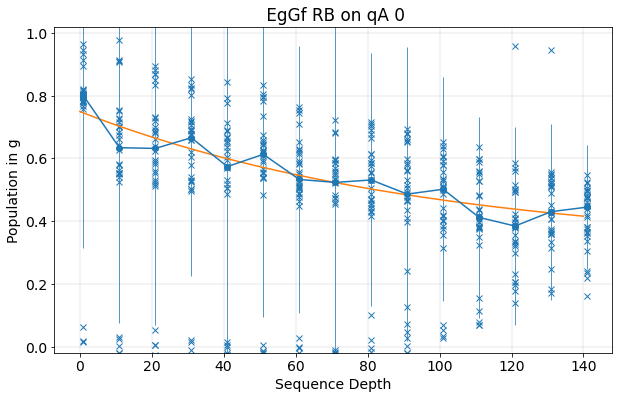

In [143]:
rbprog.analyze(fit=True)
rbprog.display(fit=True, qubit=qubit_i)

In [146]:
meas.fitting.rb_gate_fidelity(p_rb=0.989783402436281, p_irb=0.920144, d=2)

0.96482088795141

In [144]:
rbprog.save_data()

Saving s:\Connie\experiments\qramLL_4QR2\data_221007\00001_rb1Q_qubit0.h5


In [154]:
class Clifford():
    def xpulse(self):
        print('normal clifford')

    def ypulse(self):
        print('y')
        self.xpulse()

class CliffordEF(Clifford):
    def xefpulse(self):
        print('ef')

class CliffordEgGf(CliffordEF):
    def xpulse(self):
        super().xpulse()
        print('EgGf')

class SimRB(Clifford):
    def clifford(self, flag=None):
        if flag == 'X': self.xpulse()
        elif flag == 'Y': self.ypulse()
    
class RBEgGf(CliffordEgGf, SimRB):
    pass

rbeggf = RBEgGf()
print(RBEgGf.__mro__)
rbeggf.clifford(flag='X')
rbeggf.clifford(flag='Y')

(<class '__main__.RBEgGf'>, <class '__main__.CliffordEgGf'>, <class '__main__.CliffordEF'>, <class '__main__.SimRB'>, <class '__main__.Clifford'>, <class 'object'>)
normal clifford
EgGf
y
normal clifford
EgGf
